## Telecom Churn Case Study
With 21 predictor variables we need to predict whether a particular customer will switch to another telecom provider or not. In telecom terminology, this is referred to as churning and not churning, respectively.

### STEP 1: Importing and Merging Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Import all dataset
churn_data = pd.read_csv('../../Datasets/churn_data.csv')
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churn_data.shape

(7043, 9)

In [5]:
customer_data = pd.read_csv('../../Datasets/customer_data.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
customer_data.shape

(7043, 5)

In [7]:
internet_data = pd.read_csv("../../Datasets/internet_data.csv")
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


In [8]:
internet_data.shape

(7043, 9)

### Combining all data files into one consolidated dataframe

In [9]:
# Merging on 'CustomerID'
df_1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')
df_1.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No


In [10]:
df_1.shape

(7043, 13)

In [11]:
telecom = pd.merge(df_1, internet_data, how='inner', on='customerID')
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


### Step 2: Inspecting the Dataframe

In [12]:
# Dimensions of the dataframe
telecom.shape

(7043, 21)

In [13]:
# Statistical aspects of the dataframe
telecom.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [14]:
# Type of each column
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


### Step 3: Data Preparation

In [15]:
# Identify whether particular column is binary or categorical
for col in telecom.select_dtypes(exclude=np.number).columns:
    print(col+": ", telecom[col].unique())

customerID:  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
PhoneService:  ['No' 'Yes']
Contract:  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling:  ['Yes' 'No']
PaymentMethod:  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges:  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn:  ['No' 'Yes']
gender:  ['Female' 'Male']
Partner:  ['Yes' 'No']
Dependents:  ['No' 'Yes']
MultipleLines:  ['No phone service' 'No' 'Yes']
InternetService:  ['DSL' 'Fiber optic' 'No']
OnlineSecurity:  ['No' 'Yes' 'No internet service']
OnlineBackup:  ['Yes' 'No' 'No internet service']
DeviceProtection:  ['No' 'Yes' 'No internet service']
TechSupport:  ['No' 'Yes' 'No internet service']
StreamingTV:  ['No' 'Yes' 'No internet service']
StreamingMovies:  ['No' 'Yes' 'No internet service']


### Converting Binary variables (Yes/No) to (0/1)

In [16]:
vars = ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']

def binary_map(x):
    return x.map({'Yes': 1, 'No': 0})

# Applying the function to the binary variables in the dataset
telecom[vars] = telecom[vars].apply(binary_map)

In [17]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,...,0,0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,0,0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,0,0,No,Fiber optic,No,No,No,No,No,No


### For catrgorical variables with multiple levels, create dummy features (one-hot encoded)

In [18]:
# Creating a dummy variable for categorical variables and dropping the first one.
vars = ['Contract', 'PaymentMethod', 'gender', 'InternetService']
dummy_var_1 = pd.get_dummies(telecom[vars], drop_first=True)

# Adding the results to the master dataframe
telecom = pd.concat([telecom, dummy_var_1], axis=1)

telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_No
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,No,No,0,0,0,1,0,0,0,0
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,...,No,No,1,0,0,0,1,1,0,0
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,No,No,0,0,0,0,1,1,0,0
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,1,0,0,0,0,1,0,0
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,No,No,0,0,0,1,0,0,1,0


In [19]:
telecom['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

Now, out of these levels, it is best that you drop `No phone service` since it isn’t of any use because it is anyway being indicated by the variable ‘PhoneService’ already present in the dataframe.

 To simply put it, the variable `PhoneService` already tells you whether the phone services are availed or not by a particular customer. In fact, if you check the value counts of the variable `PhoneService`, following is the output that you get:

In [20]:
telecom['PhoneService'].value_counts()

1    6361
0     682
Name: PhoneService, dtype: int64

The level `No` appears 682 times which is exactly equal to the count of the level `No phone service` in `MultipleLines`.


We can see that the dummy variable for this level, i.e. `MultipleLines_No phone service` is clearly redundant since it doesn't contain any extra information and hence, to drop it is the best option at this point. 

In [21]:
# Creating dummy variables for the remaining categorical variables and dropping the level with big names.
ml = pd.get_dummies(telecom['MultipleLines'], prefix='MultipleLines')
# Dropping MultipleLines_No phone service column
ml1 = ml.drop(['MultipleLines_No phone service'], 1)
# Adding the results to master dataframe
telecom = pd.concat([telecom, ml1], axis=1)

# Creating dummy variables for the variable 'OnlineSecurity'.
os = pd.get_dummies(telecom['OnlineSecurity'], prefix='OnlineSecurity')
os1 = os.drop(['OnlineSecurity_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,os1], axis=1)

# Creating dummy variables for the variable 'OnlineBackup'.
ob = pd.get_dummies(telecom['OnlineBackup'], prefix='OnlineBackup')
ob1 = ob.drop(['OnlineBackup_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,ob1], axis=1)

# Creating dummy variables for the variable 'DeviceProtection'. 
dp = pd.get_dummies(telecom['DeviceProtection'], prefix='DeviceProtection')
dp1 = dp.drop(['DeviceProtection_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,dp1], axis=1)

# Creating dummy variables for the variable 'TechSupport'. 
ts = pd.get_dummies(telecom['TechSupport'], prefix='TechSupport')
ts1 = ts.drop(['TechSupport_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,ts1], axis=1)

# Creating dummy variables for the variable 'StreamingTV'.
st =pd.get_dummies(telecom['StreamingTV'], prefix='StreamingTV')
st1 = st.drop(['StreamingTV_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,st1], axis=1)

# Creating dummy variables for the variable 'StreamingMovies'. 
sm = pd.get_dummies(telecom['StreamingMovies'], prefix='StreamingMovies')
sm1 = sm.drop(['StreamingMovies_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,sm1], axis=1)

In [22]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,...,1,0,0,1,1,0,1,0,1,0
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,0,1,1,0,1,0,1,0,1,0
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,1,0,0,1,0,1,1,0,1,0
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,1,0,1,0,1,0,1,0,1,0


### Dropping the repeated columns

In [23]:
# We have created dummies for the below variables, so we can drop them
telecom = telecom.drop(['Contract','PaymentMethod','gender','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'], 1)

In [24]:
telecom.head()

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,1,29.85,29.85,0,0,1,0,...,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,34,1,0,56.95,1889.5,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
2,3668-QPYBK,2,1,1,53.85,108.15,1,0,0,0,...,0,1,1,0,1,0,1,0,1,0
3,7795-CFOCW,45,0,0,42.30,1840.75,0,0,0,0,...,1,0,0,1,0,1,1,0,1,0
4,9237-HQITU,2,1,1,70.70,151.65,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [25]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7043 non-null   object 
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   uint8  
 11  Cont

In [26]:
# The variable was imported as a string we need to convert it to float
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges'], errors='coerce')

In [27]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7032 non-null   float64
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   uint8  
 11  Cont

Now you can see that you have all variables as numeric.

### Checking for outliers

In [28]:
# Checking for outliers in the continuous variables
num_telecom = telecom[['tenure', 'MonthlyCharges', 'TotalCharges']]

# Checking for outliers @ 25%, 50%, 75%, 90%, 95%, 99%
num_telecom.describe(percentiles=[0.25, .5, .75, .90, .95, .99])

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
90%,69.000000,102.600000,5976.640000
95%,72.000000,107.400000,6923.590000
99%,72.000000,114.729000,8039.883000


From the distribution shown above, you can see that there no outliers in your data. The numbers are gradually increasing.

### Checking for the Missing Values and Inputing them

In [29]:
telecom.isnull().sum()

customerID                                0
tenure                                    0
PhoneService                              0
PaperlessBilling                          0
MonthlyCharges                            0
TotalCharges                             11
Churn                                     0
SeniorCitizen                             0
Partner                                   0
Dependents                                0
Contract_One year                         0
Contract_Two year                         0
PaymentMethod_Credit card (automatic)     0
PaymentMethod_Electronic check            0
PaymentMethod_Mailed check                0
gender_Male                               0
InternetService_Fiber optic               0
InternetService_No                        0
MultipleLines_No                          0
MultipleLines_Yes                         0
OnlineSecurity_No                         0
OnlineSecurity_Yes                        0
OnlineBackup_No                 

It means that 11/7043 = 0.001561834 i.e 0.1%, best is to remove these observations from the analysis

In [30]:
# Checking the percentage of missing values
round(100*(telecom.isnull().sum()/telecom.shape[0]), 2)

customerID                               0.00
tenure                                   0.00
PhoneService                             0.00
PaperlessBilling                         0.00
MonthlyCharges                           0.00
TotalCharges                             0.16
Churn                                    0.00
SeniorCitizen                            0.00
Partner                                  0.00
Dependents                               0.00
Contract_One year                        0.00
Contract_Two year                        0.00
PaymentMethod_Credit card (automatic)    0.00
PaymentMethod_Electronic check           0.00
PaymentMethod_Mailed check               0.00
gender_Male                              0.00
InternetService_Fiber optic              0.00
InternetService_No                       0.00
MultipleLines_No                         0.00
MultipleLines_Yes                        0.00
OnlineSecurity_No                        0.00
OnlineSecurity_Yes                

In [31]:
telecom.dropna(inplace=True)

telecom['TotalCharges'].isnull().sum()

0

In [32]:
# Checking the percentage of missing values
round(100*(telecom.isnull().sum()/telecom.shape[0]), 2)

customerID                               0.0
tenure                                   0.0
PhoneService                             0.0
PaperlessBilling                         0.0
MonthlyCharges                           0.0
TotalCharges                             0.0
Churn                                    0.0
SeniorCitizen                            0.0
Partner                                  0.0
Dependents                               0.0
Contract_One year                        0.0
Contract_Two year                        0.0
PaymentMethod_Credit card (automatic)    0.0
PaymentMethod_Electronic check           0.0
PaymentMethod_Mailed check               0.0
gender_Male                              0.0
InternetService_Fiber optic              0.0
InternetService_No                       0.0
MultipleLines_No                         0.0
MultipleLines_Yes                        0.0
OnlineSecurity_No                        0.0
OnlineSecurity_Yes                       0.0
OnlineBack

Now we don't have any missing values

### Step 4: Test-Train Split

In [33]:
X = telecom.drop(['Churn', 'customerID'], axis=1)
y = telecom['Churn']

X.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,1,0,1,29.85,29.85,0,1,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1,34,1,0,56.95,1889.50,0,0,0,1,0,...,1,0,0,1,1,0,1,0,1,0
2,2,1,1,53.85,108.15,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
3,45,0,0,42.30,1840.75,0,0,0,1,0,...,1,0,0,1,0,1,1,0,1,0
4,2,1,1,70.70,151.65,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [34]:
# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

### Step 5: Feature Scaling

In [35]:
scaler = StandardScaler()

X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_train.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
879,0.019693,1,1,-0.338074,-0.276449,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
5790,0.305384,0,1,-0.464443,-0.112702,0,1,1,0,0,...,0,1,1,0,1,0,0,1,0,1
6498,-1.286319,1,1,0.581425,-0.974430,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
880,-0.919003,1,1,1.505913,-0.550676,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
2784,-1.163880,1,1,1.106854,-0.835971,0,0,1,0,0,...,1,0,0,1,0,1,0,1,0,1


In [36]:
# Checking Churn Rate
telecom['Churn'].sum()/telecom.shape[0]

0.26578498293515357

We have almost 27% churn rate

### Step 6: Looking at Correlations

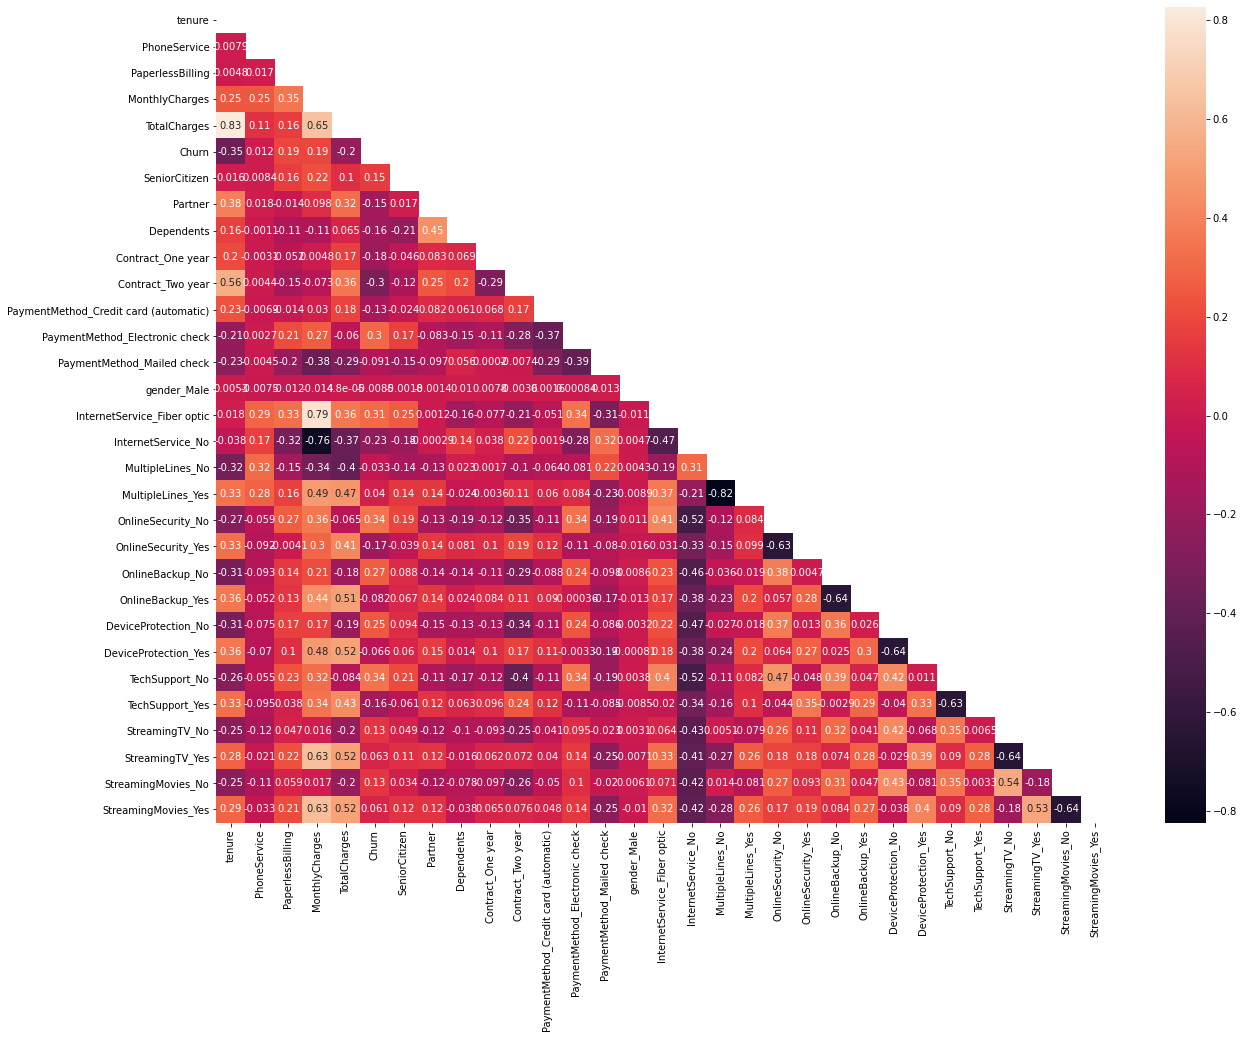

In [37]:
mask_ut = np.triu(np.ones(telecom.corr().shape, dtype=bool)).astype(bool)

plt.figure(figsize=(20, 15))
sns.heatmap(telecom.corr(), mask=mask_ut, annot=True)
plt.show()

#### Dropping highly correlated dummy variables

In [38]:
X_test = X_test.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
                       'StreamingTV_No','StreamingMovies_No'], 1)
X_train = X_train.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
                         'StreamingTV_No','StreamingMovies_No'], 1)

#### Checking the Correlation Matrix

After dropping highly correlated variables now let's check the correlation matrix again.

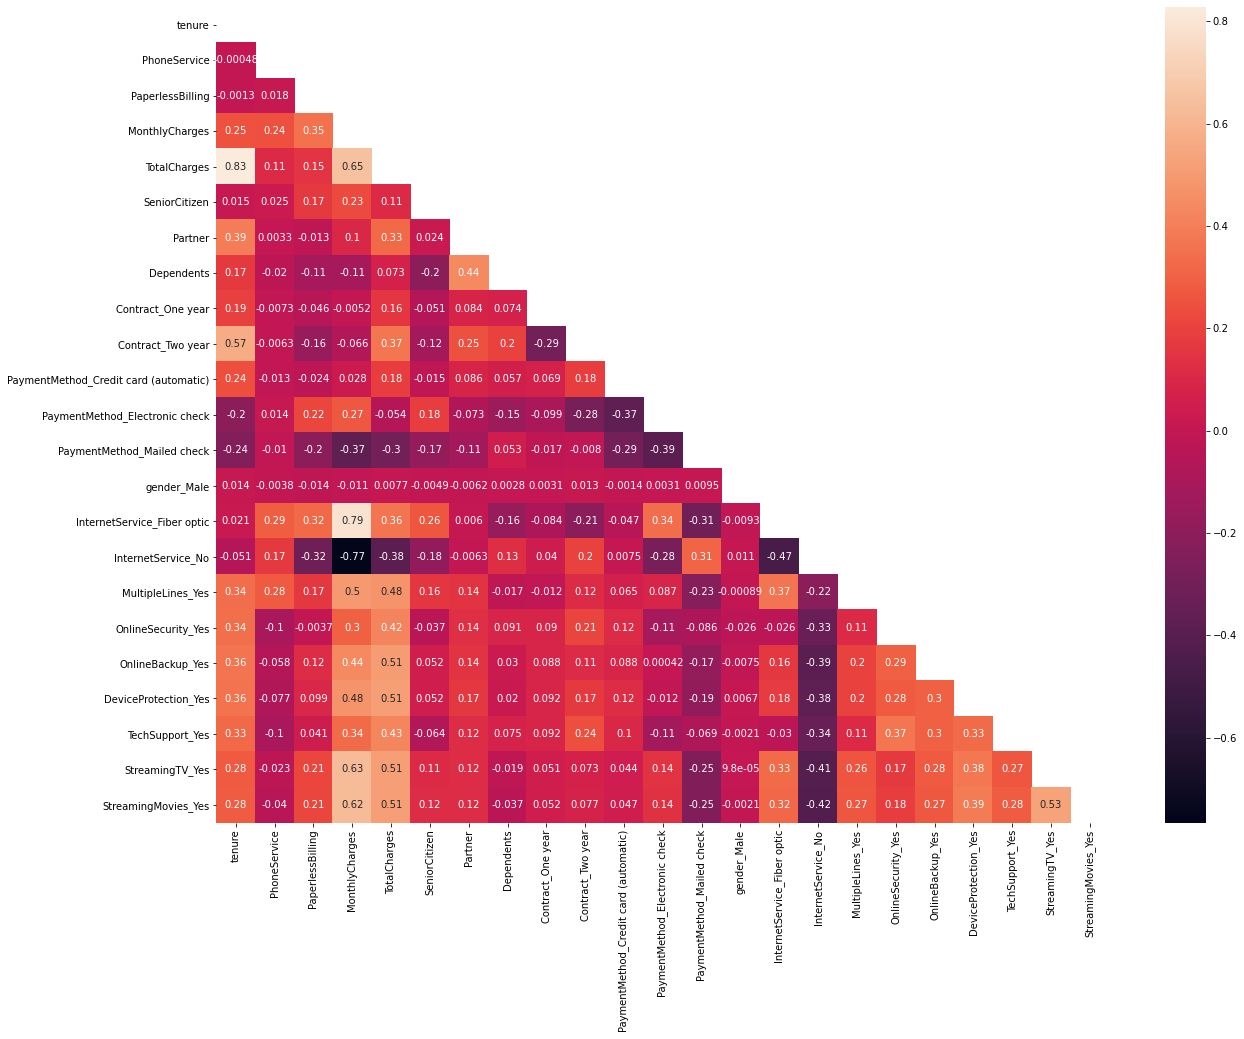

In [42]:
mask_ut = np.triu(np.ones(X_train.corr().shape, dtype=bool)).astype(bool)

plt.figure(figsize=(20, 15))
sns.heatmap(X_train.corr(), mask=mask_ut, annot=True)
plt.show()

### Step 7: Model Building
Let's start by splitting our data into a training set and a test set.

In [43]:
# Logistic regression model
logm1 = sm.GLM(y_train, (sm.add_constant(X_train)), family=sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.7
Date:                Fri, 30 Jul 2021   Deviance:                       4009.4
Time:                        19:12:57   Pearson chi2:                 6.07e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.9382      1.546     -2.547      0.011      -6.969      -0.908
tenure                                   -1.5172      0.189     -8.015      0.000      -1.888      -1.146
PhoneService                              0.9507      0.789      1.205      0.228      -0.595       2.497
PaperlessBilling                          0.3254      0.090      3.614      0.000       0.149       0.502
MonthlyCharges                           -2.1806      1.160     -1.880      0.060      -4.454       0.092
TotalCharges                              0.7332      0.198      3.705      0.000       0.345       1.121
SeniorCitizen                             0.3984      0.102      3.924      0.000       0.199       0.597
Partner                                   0.0374      0.094      0.399      0.690      -0.146       0.221
Dependents                               -0.1430      0.107     -1.332      0.183      -0.353       0.067
Contract_One year                        -0.6578      0.129     -5.106      0.000      -0.910      -0.405
Contract_Two year                        -1.2455      0.212     -5.874      0.000      -1.661      -0.830
PaymentMethod_Credit card (automatic)    -0.2577      0.137     -1.883      0.060      -0.526       0.011
PaymentMethod_Electronic check            0.1615      0.113      1.434      0.152      -0.059       0.382
PaymentMethod_Mailed check               -0.2536      0.137     -1.845      0.065      -0.523       0.016
gender_Male                              -0.0346      0.078     -0.442      0.658      -0.188       0.119
InternetService_Fiber optic               2.5124      0.967      2.599      0.009       0.618       4.407
InternetService_No                       -2.7792      0.982     -2.831      0.005      -4.703      -0.855
MultipleLines_Yes                         0.5623      0.214      2.628      0.009       0.143       0.982
OnlineSecurity_Yes                       -0.0245      0.216     -0.113      0.910      -0.448       0.399
OnlineBackup_Yes                          0.1740      0.212      0.822      0.411      -0.241       0.589
DeviceProtection_Yes                      0.3229      0.215      1.501      0.133      -0.099       0.744
TechSupport_Yes                          -0.0305      0.216     -0.141      0.888      -0.455       0.394
StreamingTV_Yes                           0.9598      0.396      2.423      0.015       0.183       1.736
StreamingMovies_Yes                       0.8484      0.396      2.143      0.032       0.072       1.624
=========================================================================================================
"""

### Step 8: Feature Selection Using RFE

In [44]:
log_reg = LogisticRegression()

rfe = RFE(log_reg, 15)

rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=15)

In [45]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('tenure', True, 1),
 ('PhoneService', False, 3),
 ('PaperlessBilling', True, 1),
 ('MonthlyCharges', True, 1),
 ('TotalCharges', True, 1),
 ('SeniorCitizen', True, 1),
 ('Partner', False, 7),
 ('Dependents', False, 6),
 ('Contract_One year', True, 1),
 ('Contract_Two year', True, 1),
 ('PaymentMethod_Credit card (automatic)', True, 1),
 ('PaymentMethod_Electronic check', False, 4),
 ('PaymentMethod_Mailed check', True, 1),
 ('gender_Male', False, 8),
 ('InternetService_Fiber optic', True, 1),
 ('InternetService_No', True, 1),
 ('MultipleLines_Yes', True, 1),
 ('OnlineSecurity_Yes', False, 2),
 ('OnlineBackup_Yes', False, 5),
 ('DeviceProtection_Yes', False, 9),
 ('TechSupport_Yes', True, 1),
 ('StreamingTV_Yes', True, 1),
 ('StreamingMovies_Yes', True, 1)]

In [46]:
cols = X_train.columns[rfe.support_]

In [47]:
X_train.columns[~rfe.support_]

Index(['PhoneService', 'Partner', 'Dependents',
       'PaymentMethod_Electronic check', 'gender_Male', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes'],
      dtype='object')

##### Assessing the model with StatsModels

In [48]:
X_train_sm = sm.add_constant(X_train[cols])
logm2 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4906
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2011.1
Date:                Fri, 30 Jul 2021   Deviance:                       4022.2
Time:                        19:12:58   Pearson chi2:                 6.25e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.2462      0.189    -11.879      0.000      -2.617      -1.876
tenure                                   -1.5596      0.187     -8.334      0.000      -1.926      -1.193
PaperlessBilling                          0.3436      0.090      3.832      0.000       0.168       0.519
MonthlyCharges                           -0.9692      0.199     -4.878      0.000      -1.359      -0.580
TotalCharges                              0.7421      0.197      3.764      0.000       0.356       1.128
SeniorCitizen                             0.4296      0.100      4.312      0.000       0.234       0.625
Contract_One year                        -0.6830      0.128     -5.342      0.000      -0.934      -0.432
Contract_Two year                        -1.2931      0.211     -6.138      0.000      -1.706      -0.880
PaymentMethod_Credit card (automatic)    -0.3724      0.113     -3.308      0.001      -0.593      -0.152
PaymentMethod_Mailed check               -0.3723      0.111     -3.345      0.001      -0.591      -0.154
InternetService_Fiber optic               1.5865      0.216      7.342      0.000       1.163       2.010
InternetService_No                       -1.6897      0.216     -7.830      0.000      -2.113      -1.267
MultipleLines_Yes                         0.3779      0.104      3.640      0.000       0.174       0.581
TechSupport_Yes                          -0.2408      0.109     -2.210      0.027      -0.454      -0.027
StreamingTV_Yes                           0.5796      0.114      5.102      0.000       0.357       0.802
StreamingMovies_Yes                       0.4665      0.111      4.197      0.000       0.249       0.684
=========================================================================================================
"""

In [49]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

879     0.192642
5790    0.275624
6498    0.599507
880     0.513571
2784    0.648233
3874    0.414846
5387    0.431184
6623    0.801788
4465    0.228194
5364    0.504575
dtype: float64

In [50]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred

array([0.19264205, 0.27562384, 0.59950707, ..., 0.03924737, 0.12914179,
       0.03145932])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [51]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.192642,879
1,0,0.275624,5790
2,1,0.599507,6498
3,1,0.513571,880
4,1,0.648233,2784


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [52]:
y_train_pred_final['predicted'] = y_train_pred_final['Churn_Prob'].map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.192642,879,0
1,0,0.275624,5790,0
2,1,0.599507,6498,1
3,1,0.513571,880,1
4,1,0.648233,2784,1


In [53]:
cm = confusion_matrix(y_train, y_train_pred_final['predicted'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted (Not Churn)', 'Predicted (Churn)']
cm_df = cm_df.rename(index={0: 'Actual (Not Churn)', 1: 'Actual (Churn)'})
cm_df

,Predicted (Not Churn),Predicted (Churn)
Actual (Not Churn),3275,360
Actual (Churn),574,713


In [54]:
# Let's check the overall accuracy.
print(accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8102397399431126


#### Checking VIFs

In [55]:
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,MonthlyCharges,14.85
3,TotalCharges,10.42
0,tenure,7.38
9,InternetService_Fiber optic,5.61
10,InternetService_No,5.27
6,Contract_Two year,3.14
13,StreamingTV_Yes,2.79
14,StreamingMovies_Yes,2.79
1,PaperlessBilling,2.76
11,MultipleLines_Yes,2.38


There are a few variables with high VIF. It's best to drop these variables as they aren't helping much with prediction and unnecessarily making the model complex. The variable 'PhoneService' has the highest VIF. So let's start by dropping that.

In [56]:
cols = cols.drop('MonthlyCharges')
cols

Index(['tenure', 'PaperlessBilling', 'TotalCharges', 'SeniorCitizen',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes'],
      dtype='object')

In [57]:
X_train_sm = sm.add_constant(X_train[cols])
logm3 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4907
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2023.1
Date:                Fri, 30 Jul 2021   Deviance:                       4046.2
Time:                        19:12:59   Pearson chi2:                 5.80e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5971      0.130    -12.296      0.000      -1.852      -1.343
tenure                                   -1.3286      0.180     -7.401      0.000      -1.681      -0.977
PaperlessBilling                          0.3533      0.089      3.958      0.000       0.178       0.528
TotalCharges                              0.4347      0.186      2.340      0.019       0.071       0.799
SeniorCitizen                             0.4569      0.099      4.601      0.000       0.262       0.652
Contract_One year                        -0.7289      0.127     -5.729      0.000      -0.978      -0.480
Contract_Two year                        -1.3277      0.210     -6.322      0.000      -1.739      -0.916
PaymentMethod_Credit card (automatic)    -0.3870      0.112     -3.442      0.001      -0.607      -0.167
PaymentMethod_Mailed check               -0.3618      0.110     -3.274      0.001      -0.578      -0.145
InternetService_Fiber optic               0.6888      0.109      6.297      0.000       0.474       0.903
InternetService_No                       -0.9555      0.156     -6.120      0.000      -1.262      -0.649
MultipleLines_Yes                         0.1700      0.094      1.814      0.070      -0.014       0.354
TechSupport_Yes                          -0.4371      0.101     -4.307      0.000      -0.636      -0.238
StreamingTV_Yes                           0.2881      0.096      2.996      0.003       0.100       0.477
StreamingMovies_Yes                       0.1944      0.096      2.031      0.042       0.007       0.382
=========================================================================================================
"""

In [58]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

879     0.227902
5790    0.228644
6498    0.674892
880     0.615868
2784    0.662260
3874    0.418199
5387    0.288133
6623    0.795137
4465    0.174332
5364    0.519088
dtype: float64

In [59]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred

array([0.22790197, 0.22864388, 0.67489226, ..., 0.05799564, 0.11065736,
       0.03727123])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [60]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.227902,879
1,0,0.228644,5790
2,1,0.674892,6498
3,1,0.615868,880
4,1,0.662260,2784


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [61]:
y_train_pred_final['predicted'] = y_train_pred_final['Churn_Prob'].map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.227902,879,0
1,0,0.228644,5790,0
2,1,0.674892,6498,1
3,1,0.615868,880,1
4,1,0.662260,2784,1


In [62]:
cm = confusion_matrix(y_train, y_train_pred_final['predicted'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted (Not Churn)', 'Predicted (Churn)']
cm_df = cm_df.rename(index={0: 'Actual (Not Churn)', 1: 'Actual (Churn)'})
cm_df

,Predicted (Not Churn),Predicted (Churn)
Actual (Not Churn),3269,366
Actual (Churn),590,697


In [63]:
# Let's check the overall accuracy.
print(accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8057700121901666


#### Checking VIFs

In [64]:
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,TotalCharges,7.46
0,tenure,6.90
5,Contract_Two year,3.07
8,InternetService_Fiber optic,2.96
13,StreamingMovies_Yes,2.62
12,StreamingTV_Yes,2.59
1,PaperlessBilling,2.55
9,InternetService_No,2.44
10,MultipleLines_Yes,2.27
11,TechSupport_Yes,1.95


In [65]:
cols = cols.drop('TotalCharges')
cols

Index(['tenure', 'PaperlessBilling', 'SeniorCitizen', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Mailed check', 'InternetService_Fiber optic',
       'InternetService_No', 'MultipleLines_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes'],
      dtype='object')

In [66]:
X_train_sm = sm.add_constant(X_train[cols])
logm4 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4908
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2025.9
Date:                Fri, 30 Jul 2021   Deviance:                       4051.9
Time:                        19:13:00   Pearson chi2:                 5.25e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.6577      0.127    -13.094      0.000      -1.906      -1.410
tenure                                   -0.9426      0.065    -14.480      0.000      -1.070      -0.815
PaperlessBilling                          0.3455      0.089      3.877      0.000       0.171       0.520
SeniorCitizen                             0.4597      0.100      4.613      0.000       0.264       0.655
Contract_One year                        -0.7218      0.127     -5.702      0.000      -0.970      -0.474
Contract_Two year                        -1.2987      0.208     -6.237      0.000      -1.707      -0.891
PaymentMethod_Credit card (automatic)    -0.3874      0.113     -3.442      0.001      -0.608      -0.167
PaymentMethod_Mailed check               -0.3307      0.110     -3.020      0.003      -0.545      -0.116
InternetService_Fiber optic               0.8052      0.097      8.272      0.000       0.614       0.996
InternetService_No                       -0.9726      0.155     -6.261      0.000      -1.277      -0.668
MultipleLines_Yes                         0.2097      0.092      2.279      0.023       0.029       0.390
TechSupport_Yes                          -0.4046      0.101     -4.019      0.000      -0.602      -0.207
StreamingTV_Yes                           0.3390      0.094      3.619      0.000       0.155       0.523
StreamingMovies_Yes                       0.2428      0.093      2.598      0.009       0.060       0.426
=========================================================================================================
"""

In [67]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

879     0.245817
5790    0.265361
6498    0.669410
880     0.630970
2784    0.682916
3874    0.399526
5387    0.275828
6623    0.798168
4465    0.198786
5364    0.529119
dtype: float64

In [68]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred

array([0.24581699, 0.26536078, 0.66940978, ..., 0.0631844 , 0.10067183,
       0.04835675])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [69]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.245817,879
1,0,0.265361,5790
2,1,0.669410,6498
3,1,0.630970,880
4,1,0.682916,2784


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [70]:
y_train_pred_final['predicted'] = y_train_pred_final['Churn_Prob'].map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.245817,879,0
1,0,0.265361,5790,0
2,1,0.669410,6498,1
3,1,0.630970,880,1
4,1,0.682916,2784,1


In [71]:
cm = confusion_matrix(y_train, y_train_pred_final['predicted'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted (Not Churn)', 'Predicted (Churn)']
cm_df = cm_df.rename(index={0: 'Actual (Not Churn)', 1: 'Actual (Churn)'})
cm_df

,Predicted (Not Churn),Predicted (Churn)
Actual (Not Churn),3278,357
Actual (Churn),597,690


In [72]:
# Let's check the overall accuracy.
print(accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8061763510767981


#### Checking VIFs

In [73]:
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Contract_Two year,2.98
7,InternetService_Fiber optic,2.67
12,StreamingMovies_Yes,2.54
11,StreamingTV_Yes,2.51
1,PaperlessBilling,2.45
9,MultipleLines_Yes,2.24
0,tenure,2.04
8,InternetService_No,2.03
10,TechSupport_Yes,1.92
3,Contract_One year,1.78


All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model only

In [74]:
cm = confusion_matrix(y_train, y_train_pred_final['predicted'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted (Not Churn)', 'Predicted (Churn)']
cm_df = cm_df.rename(index={0: 'Actual (Not Churn)', 1: 'Actual (Churn)'})
cm_df

,Predicted (Not Churn),Predicted (Churn)
Actual (Not Churn),3278,357
Actual (Churn),597,690


In [75]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.8061763510767981

## Metrics beyond simply accuracy

In [76]:
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred_final['predicted']).ravel()

In [77]:
# Sensitivity
round(tp / (tp+fn), 2)

0.54

In [78]:
# Specificity
round(tn / (tn+fp), 2)

0.9

In [79]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(fp/ float(tn+fp))

0.09821182943603851


In [80]:
# positive predictive value 
print (tp / float(tp+fp))

0.6590257879656161


In [81]:
# Negative predictive value
print (tn / float(tn+ fn))

0.8459354838709677


### Step 9: Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [82]:
y_train_pred_final

,Churn,Churn_Prob,CustID,predicted
0,0,0.245817,879,0
1,0,0.265361,5790,0
2,1,0.669410,6498,1
3,1,0.630970,880,1
4,1,0.682916,2784,1
...,...,...,...,...
4917,0,0.024976,79,0
4918,0,0.095470,3934,0
4919,0,0.063184,5964,0
4920,0,0.100672,6947,0


In [83]:
def get_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs, drop_intermediate=False)
    
    auc_score = roc_auc_score(actual, probs)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR or [1-TNR]')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characterstic ')
    plt.legend(loc='lower right')
    plt.show()

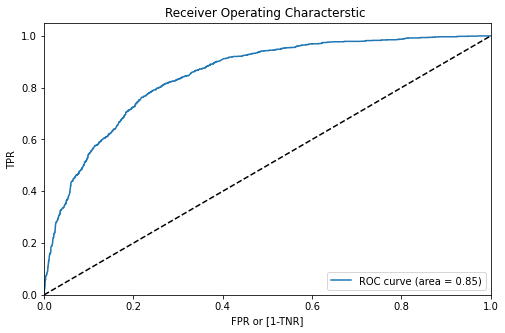

In [84]:
get_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

### Step 10: Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [85]:
# Let's create columns with different probability cutoffs 
numbers = [float(i)/10 for i in range(10)]

for i in numbers:
    y_train_pred_final[i] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.245817,879,0,1,1,1,0,0,0,0,0,0,0
1,0,0.265361,5790,0,1,1,1,0,0,0,0,0,0,0
2,1,0.669410,6498,1,1,1,1,1,1,1,1,0,0,0
3,1,0.630970,880,1,1,1,1,1,1,1,1,0,0,0
4,1,0.682916,2784,1,1,1,1,1,1,1,1,0,0,0


In [86]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame(columns=['prob', 'accuracy', 'sensitivity', 'specificity'])

for i in numbers:
    cm = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i])
    accuracy = (cm[1, 1] + cm[0, 0]) / sum(sum(cm))
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])
    
    cutoff_df.loc[i] = [i, accuracy, sensitivity, specificity]
cutoff_df.reset_index().drop('index', axis=1, inplace=True)

In [87]:
cutoff_df

,prob,accuracy,sensitivity,specificity
0.0,0.0,0.261479,1.000000,0.000000
0.1,0.1,0.614994,0.943279,0.498762
0.2,0.2,0.721861,0.846154,0.677854
0.3,0.3,0.770012,0.776224,0.767813
0.4,0.4,0.790532,0.636364,0.845117
0.5,0.5,0.806176,0.536131,0.901788
0.6,0.6,0.798050,0.380730,0.945805
0.7,0.7,0.776310,0.196581,0.981568
0.8,0.8,0.747867,0.041181,0.998074
0.9,0.9,0.738521,0.000000,1.000000


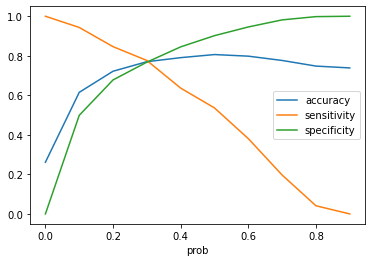

In [88]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [89]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.245817,879,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.265361,5790,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.669410,6498,1,1,1,1,1,1,1,1,0,0,0,1
3,1,0.630970,880,1,1,1,1,1,1,1,1,0,0,0,1
4,1,0.682916,2784,1,1,1,1,1,1,1,1,0,0,0,1


In [90]:
accuracy_score(y_train_pred_final['Churn'], y_train_pred_final['final_predicted'])

0.7700121901665989

In [91]:
cm = confusion_matrix(y_train, y_train_pred_final['final_predicted'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted (Not Churn)', 'Predicted (Churn)']
cm_df = cm_df.rename(index={0: 'Actual (Not Churn)', 1: 'Actual (Churn)'})
cm_df

,Predicted (Not Churn),Predicted (Churn)
Actual (Not Churn),2791,844
Actual (Churn),288,999


In [92]:
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred_final['final_predicted']).ravel()

In [93]:
# Sensitivity
round(tp / (tp + fn), 2)

0.78

In [94]:
# Specificity
round(tn / (tn + fp), 2)

0.77

In [95]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(fp/ float(tn+fp))

0.23218707015130674


In [96]:
# positive predictive value 
print (tp / float(tp + fp))

0.5420510037981552


In [97]:
# Negative predictive value
print (tn / float(tn + fn))

0.9064631373822669


## Precision and Recall

In [98]:
#Looking at the confusion matrix again

In [99]:
confusion = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion

array([[3278,  357],
       [ 597,  690]], dtype=int64)

##### Precision
TP / TP + FP

In [100]:
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.6590257879656161

##### Recall
TP / TP + FN

In [101]:
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.5361305361305362

Using sklearn utilities for the same

In [102]:
from sklearn.metrics import precision_score, recall_score

In [103]:
?precision_score

In [104]:
precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.6590257879656161

In [105]:
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.5361305361305362

### Precision and recall tradeoff

In [106]:
from sklearn.metrics import precision_recall_curve

In [107]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

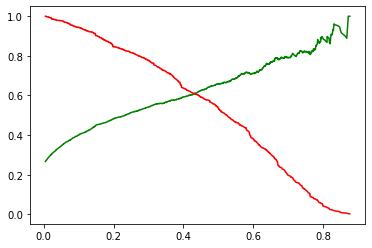

In [108]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Step 11: Making predictions on the test set

In [109]:
X_test[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(X_test[['tenure','MonthlyCharges','TotalCharges']])

In [110]:
X_test = X_test[cols]
X_test.head()

,tenure,PaperlessBilling,SeniorCitizen,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,MultipleLines_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
942,-0.347623,1,0,0,0,1,0,1,0,0,0,0,1
3730,0.999203,1,0,0,0,1,0,1,0,1,0,1,1
1761,1.040015,1,0,0,1,1,0,0,1,1,0,0,0
2283,-1.286319,1,0,0,0,0,1,1,0,0,0,0,0
1872,0.346196,0,0,0,1,0,0,0,1,0,0,0,0


In [111]:
X_test_sm = sm.add_constant(X_test)

Making predictions on the test set

In [112]:
y_test_pred = res.predict(X_test_sm)

In [113]:
y_test_pred[:10]

942     0.419725
3730    0.260232
1761    0.008650
2283    0.592626
1872    0.013989
1970    0.692893
2532    0.285289
1616    0.008994
2485    0.602307
5914    0.145153
dtype: float64

In [114]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

y_test_df

,Churn
942,0
3730,1
1761,0
2283,1
1872,0
...,...
1289,0
3508,0
6765,0
3598,0


In [115]:
y_test_df = pd.concat([y_test_df, pd.DataFrame(y_test_pred, columns=['Churn_Prob'])], axis=1)
y_test_df['CustID'] = y_test_df.index
y_test_df.reset_index(drop=True, inplace=True)
y_test_df

,Churn,Churn_Prob,CustID
0,0,0.419725,942
1,1,0.260232,3730
2,0,0.008650,1761
3,1,0.592626,2283
4,0,0.013989,1872
...,...,...,...
2105,0,0.023041,1289
2106,0,0.054121,3508
2107,0,0.008348,6765
2108,0,0.503619,3598


In [116]:
y_test_df['final_predicted'] = y_test_df.Churn_Prob.map(lambda x: 1 if x > 0.42 else 0)

y_test_df

,Churn,Churn_Prob,CustID,final_predicted
0,0,0.419725,942,0
1,1,0.260232,3730,0
2,0,0.008650,1761,0
3,1,0.592626,2283,1
4,0,0.013989,1872,0
...,...,...,...,...
2105,0,0.023041,1289,0
2106,0,0.054121,3508,0
2107,0,0.008348,6765,0
2108,0,0.503619,3598,1


In [118]:
cm = confusion_matrix(y_test, y_test_df['final_predicted'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted (Not Churn)', 'Predicted (Churn)']
cm_df = cm_df.rename(index={0: 'Actual (Not Churn)', 1: 'Actual (Churn)'})
cm_df

,Predicted (Not Churn),Predicted (Churn)
Actual (Not Churn),1286,242
Actual (Churn),214,368


In [119]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_df['final_predicted']).ravel()

In [120]:
# Sensitivity
round(tp / (tp + fn), 2)

0.63

In [121]:
# Specificity
round(tn / (tn + fp), 2)

0.84